# Machine Learning Volatility Modeling
## Master's Thesis - Empirical Study 
### Università della Svizzera italiana

Pietro Bonazzi - pietro.bonazzi@usi.ch

Network Optimization - v.2

In [1]:
# Import packages 
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend 
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from scipy.stats import norm
from dieboldmariano import dm_test
from xgboost import XGBRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
def prepare_data(data_stock, mkt_covariates, lags_RV = [1,5,22], lags_RQ = [1,5,22], RQ_add = True):
    '''
    This function prepares the data for the model.

    Parameters
    ----------
    data_stock : DataFrame
        DataFrame containing the stock data.
    mkt_covariates : DataFrame
        DataFrame containing the market covariates.
    lags_RV : list, optional
        List of lags for the realized variance. The default is [1,5,22].
    lags_RQ : list, optional    
        List of lags for the realized quarticity. The default is [1,5,22].
    RQ_add : bool, optional
        Boolean to decide whether to add the realized quarticity. The default is True.
    '''

    data_stock.index = pd.to_datetime(data_stock.index)
    data_stock['RV_'+  str(lags_RV[0])] = data_stock['RV'].rolling(window=lags_RV[0]).mean()
    data_stock['RV_'+  str(lags_RV[1])] = data_stock['RV_'+  str(lags_RV[0])].rolling(window=lags_RV[1]).mean()
    data_stock['RV_'+  str(lags_RV[2])] = data_stock['RV_'+  str(lags_RV[0])].rolling(window=lags_RV[2]).mean()

    if RQ_add == True: 
        data_stock['RQ_'+  str(lags_RQ[0])] = data_stock['RQ'].rolling(window=lags_RQ[0]).mean()
        data_stock['RQ_'+  str(lags_RQ[1])] = data_stock['RQ_'+  str(lags_RQ[0])].rolling(window=lags_RQ[1]).mean()
        data_stock['RQ_'+  str(lags_RQ[2])] = data_stock['RQ_'+  str(lags_RQ[0])].rolling(window=lags_RQ[2]).mean()

    mkt_covariates.index = pd.to_datetime(mkt_covariates.index)
    mkt_covariates['CHFUSD'] = mkt_covariates['CHFUSD'].pct_change()
    mkt_covariates['CHFEUR'] = mkt_covariates['CHFEUR'].pct_change()
    mkt_covariates['GSWISS10'] = mkt_covariates['GSWISS10'].diff()
    mkt_covariates['CCFASZE'] = mkt_covariates['CCFASZE'].diff()
    mkt_covariates['SFSNTC'] = mkt_covariates['SFSNTC'].diff()
    mkt_covariates['SSARON'] = mkt_covariates['SSARON'].diff()
    mkt_covariates = mkt_covariates[30:-1]

    data = pd.concat([data_stock, mkt_covariates], axis=1, join='inner')
    data['Returns'] = data['Returns'].shift(-1)
    data['RV'] = data['RV'].shift(-1)
    data['RQ'] = data['RQ'].shift(-1)
    data.dropna(inplace=True)
    data = pd.DataFrame(data)
    
    return data

In [4]:
def create_df_selected_features(data, features):

    # Select the features
    select_features = ['Returns', 'RV'] + features
    data = data[select_features]

    # Define the train, validation and test dates
    train_date = data.index[int(len(data)*0.6)] # 60% of the data
    test_date = data.index[-1] # 30% of the data

    # Split the data into train and test
    df_train = data.loc[:train_date]
    df_test = data.loc[train_date:]
    df_test = df_test.drop(df_test.index[0])

    return df_train, df_test

In [5]:
# Import data for testing
conn = sqlite3.connect('data.db')
df_stock = pd.read_sql_query("SELECT * FROM UBSG", conn).set_index('date')
df_mkt = pd.read_sql_query("SELECT * FROM mkt_covariates", conn).set_index('date')
all_features = [df_stock.columns, df_mkt.columns]
all_features

[Index(['Returns', 'RV', 'RQ', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
        'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL',
        'NEWS_SENTIMENT_DAILY_AVG'],
       dtype='object'),
 Index(['VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON',
        'EURCHFV3M', 'USDCHFV3M'],
       dtype='object')]

In [6]:
# Prepare data
data = prepare_data(df_stock, df_mkt, lags_RV = [1,5,22], lags_RQ = [1,5,22], RQ_add = True)

In [7]:
def har_bmk (df_train, df_test, plot = False):

    '''
    HAR benchmark model. Default RV lags are 1, 5 and 22.

    Parameters
    ----------
    df_train : pandas.DataFrame
        Train data.
    df_test : pandas.DataFrame
        Test data.
    plot : bool, optional

    '''

    model = LinearRegression()

    # Fit the model
    model.fit(df_train.drop(['Returns', 'RV'], axis=1), df_train['RV'])
    prediction_bmk = model.predict(df_test.drop(['Returns', 'RV'], axis=1))

    # Calculate the RMSE
    rmse = np.sqrt(mse(df_test['RV'], prediction_bmk))
    
    results_bmk = pd.DataFrame({'pred_bmk': prediction_bmk, 'RV': df_test['RV']})
    results_bmk.index = df_test.index


    # Calculate the violation ratio
    alpha = 0.05
    var = pd.DataFrame({'VAR': results_bmk['pred_bmk']* norm.ppf(alpha), 'Returns': df_test['Returns']})
    violation_ratio = (var['Returns'] < var['VAR']).sum()/len(df_test)

    #DMW test (not necessary for benchmark model)
    dmw_test = (0,0)

    if plot is True:
        plt.rcParams["font.family"] = "Times New Roman"
        fig, ax = plt.subplots(figsize=(11, 3))
        ax.plot(results_bmk['pred_bmk'], label='prediction', color='black', linewidth=0.9)
        ax.plot(results_bmk['RV'], label='RV', color='grey', linewidth=0.7)
        ax.set_title('HAR_benchmark')   
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.show()
    

    return rmse, violation_ratio, dmw_test, results_bmk

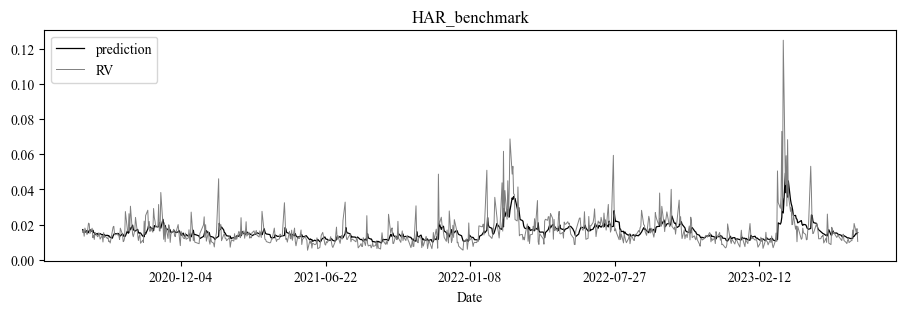

(0.007803041619598128,
 0.06040268456375839,
 (0, 0),
             pred_bmk        RV
 date                          
 2020-07-21  0.017157  0.015625
 2020-07-22  0.015488  0.017177
 2020-07-23  0.016100  0.013381
 2020-07-24  0.015592  0.018016
 2020-07-27  0.016645  0.014328
 ...              ...       ...
 2023-06-22  0.013566  0.013794
 2023-06-23  0.013298  0.020653
 2023-06-26  0.015141  0.015471
 2023-06-27  0.014639  0.017731
 2023-06-28  0.015500  0.010431
 
 [745 rows x 2 columns])

In [8]:
#### Test function ####

# Select features
features = ['RV_1', 'RV_5', 'RV_22']
df_train, df_test = create_df_selected_features (data, features)

df_test = df_test.loc['2020-07-21':]

# Results
rmse, violation_ratio, dmw_test, results_bmk = har_bmk (df_train=df_train, df_test=df_test, plot = True)
rmse, violation_ratio, dmw_test, results_bmk

In [9]:
def lstm_single_layer(df_train, df_test, results_bmk, neurons = '20', n_past = '22', batch_size = '32', plot = False): 

    '''
    LSTM single layer model.

    Parameters
    ----------
    df_train : pandas.DataFrame
        Train data.
    df_test : pandas.DataFrame
        Test data.
    results_bmk : pandas.DataFrame  
        Results of the HAR benchmark model.
    neurons : str, optional
        Number of neurons in the LSTM layer. The default is '20'.
    n_past : str, optional
        Number of past observations to use as input. The default is '22'.
    batch_size : str, optional
        Batch size. The default is '32'.
    plot : bool, optional   
    '''


    np.random.seed(2024)
    
    n_dims = df_train.shape[1]-2
    x_train, y_train = windowed_dataset(df_train.drop(['Returns', 'RV'], axis=1), df_train['RV'], n_past)

    # Define the model
    lstm = tf.keras.models.Sequential([ 
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),

        tf.keras.layers.LSTM(neurons),
        
        tf.keras.layers.Dense(1)
    ])
    
    def rmse(y_true, y_pred):
        loss = backend.sqrt(backend.mean(backend.square((y_true - y_pred))))
        return loss

    lstm.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmse])
    
    checkpoint_cb = ModelCheckpoint('NN_models/lstm_single_layer.h5',
                                save_best_only=True,
                                monitor='val_rmse')

    early_stopping_cb = EarlyStopping(patience=150,
                                  restore_best_weights=True,
                                  monitor='val_rmse')
    
    lstm_res = lstm.fit(x_train, y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.3, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=300)
    
    x_test, y_test = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['RV'], n_past)
    x, returns = windowed_dataset(df_test.drop(['Returns', 'RV'], axis=1), df_test['Returns'], n_past)

    # Predictions
    pred = lstm.predict(x_test)
    df_results = pd.DataFrame({'RV': df_test['RV'].iloc[n_past-1:], 'pred': pred.flatten(), 'returns': returns})


    # Calculate the RMSE
    rmse = np.sqrt(mse(df_results['RV'], df_results['pred']))

    # Calculate the violation ratio
    alpha = 0.05
    var = pd.DataFrame({'VAR': df_results['pred']* norm.ppf(alpha), 'Returns': df_results['returns']})
    violation_ratio = (var['Returns'] < var['VAR']).sum()/len(df_results)

    # Calculate the Diebold-Mariano test
    df_dmw_test = pd.concat([results_bmk['pred_bmk'], df_results['pred'], df_results['RV']], axis=1).dropna()
    dmw_test = dm_test(df_dmw_test['RV'], df_dmw_test['pred_bmk'], df_dmw_test['pred'], one_sided=True)

    if plot == True:
        plt.rcParams["font.family"] = "Times New Roman"
        fig, ax = plt.subplots(figsize=(11, 3))
        ax.plot(df_results['pred'], label='prediction', color='black', linewidth=0.9)
        ax.plot(df_results['RV'], label='RV', color='grey', linewidth=0.7)
        ax.set_title('LSTM_single_layer')   
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.show()

    return rmse, violation_ratio, dmw_test

In [10]:
# Function to prepare the data for the LSTM model 
def windowed_dataset(x_series, y_series, n_past):
    dataX, dataY = [], []
    for i in range((n_past-1), len(x_series)):
        start_idx = x_series.index[i-n_past+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])
    return np.array(dataX), np.array(dataY)

### Optimization with manual search

In [84]:
neuron_range = [2,8,16,64,128]
n_past_range = [2,4,8,16,32,64,128]
batch_size = [2,8,16,32,64,128]

# Combination 
comb = [(neuron, n_past, batch) for neuron in neuron_range for n_past in n_past_range for batch in batch_size]

In [ ]:
results = []

for i in range(len(comb)):
    rmse, violation_ratio, dmw_test = lstm_single_layer(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = comb[i][0], n_past = comb[i][1], batch_size = comb[i][2], plot = False)
    results.append([comb[i][0], comb[i][1], comb[i][2], rmse, violation_ratio, dmw_test[0], dmw_test[1]])

In [22]:
results_test = results.copy()

In [74]:
results_test = pd.DataFrame(results_test, columns=['neurons', 'n_past', 'batch_size', 'rmse', 'violation_ratio', 'dmw_test', 'p_value'])
results_test.sort_values(by=['rmse'], ascending=True).head(10)

,neurons,n_past,batch_size,rmse,violation_ratio,dmw_test,p_value
34,2,32,128,0.005041,0.063961,-6.882483,6.250756e-12
37,2,64,8,0.005122,0.066581,-6.930851,4.537864e-12
33,2,32,64,0.005224,0.068881,-8.661757,1.434874e-17
31,2,32,16,0.005248,0.066421,-6.594858,4.036300e-11
38,2,64,16,0.005279,0.067862,-8.712667,9.553896e-18
39,2,64,32,0.005341,0.072983,-9.088012,4.496492e-19
24,2,16,16,0.005406,0.065139,-7.299388,3.718687e-13
47,2,128,64,0.005445,0.069735,-8.714616,1.006952e-17
32,2,32,32,0.005487,0.073801,-9.246996,1.195488e-19
43,2,128,4,0.005539,0.073919,-9.508907,1.425078e-20


### Testing Results

26/26 [==============================] - 0s 922us/step


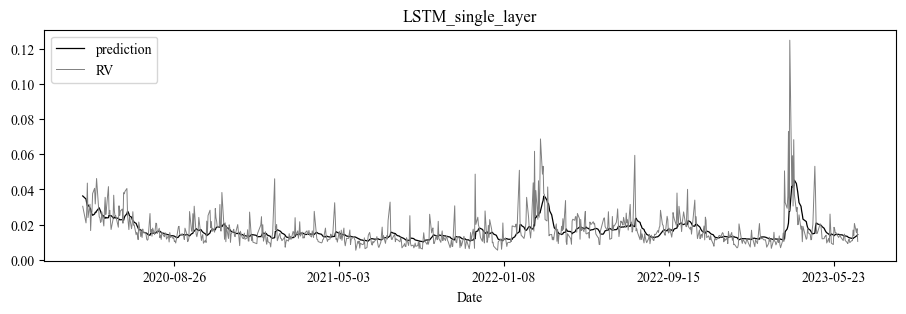

(0.007956265078674656,
 0.06273062730627306,
 (-2.486644075042773, 0.006556832733256129))

In [17]:
#### Test function ####

# Select features
features = ['RV_1', 'RQ_1']

df_train, df_test = create_df_selected_features (data, features)

# Test function
rmse, violation_ratio, dmw_test = lstm_single_layer(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = 2, n_past = 32, batch_size = 32, plot = True)
rmse, violation_ratio, dmw_test